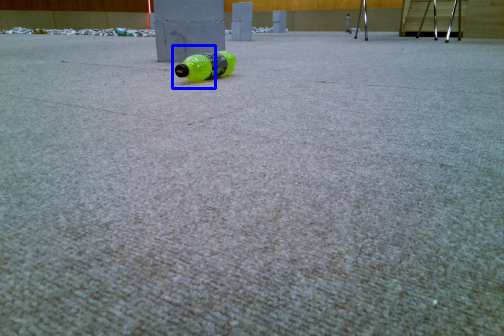

In [95]:
import matplotlib.pyplot as plt
cv.imwrite(IMAGES_PATH + "cam_haar.png", img)
Image(filename = IMAGES_PATH + 'cam_haar.png')

In [98]:
import io
import time
import picamera
import cv2
import numpy as np

with picamera.PiCamera() as camera:
    camera.resolution = (504, 336)
    camera.rotation = 180
    camera.framerate = 60
    stream = io.BytesIO()
    for foo in camera.capture_continuous(stream, format='bmp', burst=True):
        # Truncate the stream to the current position (in case
        # prior iterations output a longer image)
        start = time.time()
        stream.truncate()
        stream.seek(0)
        file_bytes = np.asarray(bytearray(stream.read()), dtype=np.uint8)
        
        img = cv2.imdecode(file_bytes, cv.IMREAD_COLOR)
        process(img)
        stream.seek(0)
        print("total time: ", time.time() - start)

detection:  0.3958137035369873
bottle number:  0
total time:  0.40627288818359375
detection:  0.38863420486450195
bottle number:  2
total time:  0.3990650177001953
detection:  0.35732102394104004
bottle number:  0
total time:  0.361574649810791
detection:  0.35828232765197754
bottle number:  1
total time:  0.3687734603881836


KeyboardInterrupt: 

In [86]:
def process(img):
    #robot_x, robot_y, robot_a = get_robot_pos_angle(ser)
    robot_x = float(10)/10
    robot_y = float(10)/10
    robot_a = float(10)
    # resize to increase speed detection
    img_height,img_width = img.shape[:2]   
    start = time.time()
    bottles = bottle_cascade.detectMultiScale(img, minNeighbors=10)
    #print("detection: ", time.time() - start)
    tcp_msg = ""
    msg_to_send = False
    bottle_x = []
    bottle_y = []
    print("bottle number: ", len(bottles))

    for (x,y,w,h) in bottles:
        cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        #bottomLeftCornerOfText = (x-10,y-10)
        #cv.putText(img,str(i), bottomLeftCornerOfText,font,fontScale,fontColor,lineType)
        center = calcul_low_center(x,y,w,h)
        bottle_dist, bottle_a = calcul_bottle_dist_angle(center, img_width, img_height)
        if bottle_dist < 400:
            cx, cy = calcul_object_pos(robot_x, robot_y, robot_a, 40, bottle_a)
            xb, yb = calcul_object_pos(cx, cy, robot_a, bottle_dist, bottle_a)
            if (xb < 350 and yb > 450) or (xb > 480 and yb > 580) or (xb < 200 and yb < 200) or xb < 10 or yb < 10 or xb > 790 or yb > 790:
                continue
            else:
                msg_to_send = True
                bottle_x.append(int(round(xb)))
                bottle_y.append(int(round(yb)))
        else:
            continue


In [1]:
import picamera
import time
from IPython.display import Image
import math
import serial
import socket
import re
import cv2 as cv

IMAGES_PATH = "images/"
utils = "Utils/"

bottle_cascade = cv.CascadeClassifier(utils + 'biggest_haar.xml')

In [2]:
''''''
''' TCP COMMUNICATION '''
''''''

def enable_tcp_com(BUFFER_SIZE):
    TCP_IP = '192.168.43.58' 
    TCP_PORT = 5005
    while(1):
        try:
            s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            s.connect((TCP_IP, TCP_PORT))
            s.setblocking(0)
        except:
            continue
        else:
            print("TCP com enabled!")
            break

    return s

def send_message(s, msg):
    s.send((msg).encode())
    
def check_data_received(s, msg, BUFFER_SIZE):
    ready = select.select([s], [], [], 0.2)
    print(ready)
    if ready[0]:
        data = s.recv(BUFFER_SIZE)
        print(data.decode())
        return data.decode()[-9:] == msg
    else :
        print("Data was not received")
        return None

def close_connection(s):
    s.close()

''''''
''' Robot position '''
''''''


def open_ser():
    ser = serial.Serial(
        port='../../../dev/ttyS0', #Replace ttyS0 with ttyAM0 for Pi1,Pi2,Pi0
        baudrate = 115200,
        parity=serial.PARITY_NONE,
        stopbits=serial.STOPBITS_ONE,
        bytesize=serial.EIGHTBITS,
        timeout=1
    )
    return ser

def get_robot_pos_angle(ser):
    buffer = ''
    ser.flushInput()
    time.sleep(0.1)
    timeout = time.time() + 5 #5s timeout
    while True:
        # last_received = ser.readline()
        buffer += str(ser.read(ser.inWaiting()))
        
        if len(buffer.split('\\n')) >= 3:
            last_received = buffer.split('\\n')[-2]
            pos_angle = re.findall('[+-]?\d+\.\d+', last_received )
            if len(pos_angle) == 3:
                return pos_angle[0], pos_angle[1], pos_angle[2]
        if time.time() > timeout:
            return -1, -1, -1
            break


''''''
''' Bottle position '''
''''''

def calcul_object_pos(xr,yr,ar,dist_rb,a_rb):
    ab = ar + a_rb

    rel_xb = dist_rb * math.cos(math.radians(ab))
    rel_yb = dist_rb * math.sin(math.radians(ab))
    
    real_xb = xr + rel_xb
    real_yb = yr + rel_yb
    return real_xb,real_yb


def calcul_low_center(x,y,w,h):
    return (x+w/2), (y+h)

def multiDimenDist(point1,point2):
   #find the difference between the two points, its really the same as below
    deltaVals = [point2[dimension]-point1[dimension] for dimension in range(len(point1))]
    runningSquared = 0
   #because the pythagarom theorm works for any dimension we can just use that
    for coOrd in deltaVals:
        runningSquared += coOrd**2
    return runningSquared**(1/2)

def findVec(point1,point2,unitSphere = False):
    #setting unitSphere to True will make the vector scaled down to a sphere with a radius one, instead of it's orginal length
    finalVector = [0 for coOrd in point1]
    for dimension, coOrd in enumerate(point1):
        #finding total differnce for that co-ordinate(x,y,z...)
        deltaCoOrd = point2[dimension]-coOrd
        #adding total difference
        finalVector[dimension] = deltaCoOrd
    if unitSphere:
        totalDist = multiDimenDist(point1,point2)
        unitVector =[]
        for dimen in finalVector:
            unitVector.append( dimen/totalDist)
            return unitVector
    else:
        return finalVector

def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def calcul_angle(v1, v2):
    return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

def calcul_bottle_dist_angle(center, img_width, img_height):
    vect1 = findVec([img_width/2, img_height],[img_width/2, 0])
    vect2 = findVec([img_width/2, img_height],[center[0],center[1]])
    angle_br = math.degrees(calcul_angle(vect1,vect2))*0.7
    if center[0] > img_width/2:
        angle_br = -angle_br
    dist_y = 20546*(center[1]**(-1.279))
    dist = dist_y / math.cos(math.radians(angle_br))
    return dist, angle_br

# Main

In [5]:
BUFFER_SIZE = 1024
s = enable_tcp_com(BUFFER_SIZE)

TCP com enabled!


In [9]:
ser = open_ser()

In [8]:
'''font = cv.FONT_HERSHEY_SIMPLEX
fontScale = 1
fontColor = (255,255,255)
lineType = 2
'''

In [11]:
get_robot_pos_angle(ser)

('1000.00', '1000.00', '91.16')

In [ ]:
with picamera.PiCamera() as camera:
    camera.resolution = (504, 336)
    camera.rotation = 180
    camera.framerate = 60
    camera.start_preview()
    # Give the camera some warm-up time
    time.sleep(2)
    c = 0
    while(True):
        robot_x, robot_y, robot_a = get_robot_pos_angle(ser)
        robot_x = float(robot_x)/10
        robot_y = float(robot_y)/10
        robot_a = float(robot_a)
        '''robot_x= 400
        robot_y = 400
        robot_a = 90'''

        camera.capture(IMAGES_PATH + "cam.bmp")
        img = cv.imread(IMAGES_PATH + 'cam.bmp')

        # resize to increase speed detection
        img_height,img_width = img.shape[:2]   

        bottles = bottle_cascade.detectMultiScale(img, minNeighbors=8)
        tcp_msg = ""
        msg_to_send = False
        bottle_x = []
        bottle_y = []
        i = 0

        for (x,y,w,h) in bottles:
            #cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
            #bottomLeftCornerOfText = (x-10,y-10)
            #cv.putText(img,str(i), bottomLeftCornerOfText,font,fontScale,fontColor,lineType)
            center = calcul_low_center(x,y,w,h)
            bottle_dist, bottle_a = calcul_bottle_dist_angle(center, img_width, img_height)
            if bottle_dist < 400:
                cx, cy = calcul_object_pos(robot_x, robot_y, robot_a, 40, bottle_a)
                xb, yb = calcul_object_pos(cx, cy, robot_a, bottle_dist, bottle_a)
                if (xb < 350 and yb > 450) or (xb > 480 and yb > 580) or (xb < 200 and yb < 200) or xb < 10 or yb < 10 or xb > 790 or yb > 790:
                    continue
                else:
                    msg_to_send = True
                    bottle_x.append(int(round(xb)))
                    bottle_y.append(int(round(yb)))
            else:
                continue
            i = i + 1
        if msg_to_send:
            msg_to_send = False
            for i in range(0, len(bottle_x)):
                tcp_msg = tcp_msg + "(" + str(bottle_x[i])+ "," + str(bottle_y[i]) + ");"
            print(("Robot's position: ({},{}), angle: {}").format(robot_x,robot_y,robot_a))
            print(("-- Bottle's position: {}").format(tcp_msg))
            send_message(s, tcp_msg )
    

cv.imwrite(IMAGES_PATH + "cam_haar.png", img)
Image(filename = IMAGES_PATH + 'cam_haar.png')

Robot's position: (98.11,195.78699999999998), angle: 90.25
Bottle's position: (73,280);(27,338);(68,268);(54,266);
Robot's position: (99.7,281.217), angle: 102.79
Bottle's position: (40,307);(41,307);(36,299);
Robot's position: (204.108,324.95300000000003), angle: -7.37
Bottle's position: (418,327);
Robot's position: (293.529,314.95300000000003), angle: -6.95
Bottle's position: (496,202);(478,343);
Robot's position: (495.8,277.23), angle: -95.09
Bottle's position: (450,213);
Robot's position: (491.42600000000004,265.894), angle: -119.2
Bottle's position: (466,119);(456,206);
Robot's position: (511.533,283.456), angle: -142.76
Bottle's position: (462,204);
Robot's position: (576.863,243.68), angle: 3.43
Bottle's position: (639,221);
Robot's position: (613.665,250.45), angle: 14.7
Bottle's position: (708,324);
Robot's position: (613.669,250.45100000000002), angle: 14.74
Bottle's position: (720,331);
Robot's position: (613.669,250.45100000000002), angle: 14.74
Bottle's position: (720,331)

Robot's position: (553.424,461.209), angle: 23.18
Bottle's position: (675,547);
Robot's position: (553.136,461.08500000000004), angle: 23.91
Bottle's position: (682,555);
Robot's position: (553.286,461.151), angle: 23.75
Bottle's position: (683,554);
Robot's position: (553.265,461.14300000000003), angle: 23.72
Bottle's position: (676,550);
Robot's position: (553.3149999999999,461.16499999999996), angle: 23.64
Bottle's position: (673,546);
Robot's position: (553.135,461.08900000000006), angle: 24.06
Bottle's position: (679,549);
Robot's position: (553.182,461.108), angle: 23.95
Bottle's position: (680,548);
Robot's position: (553.452,461.225), angle: 23.15
Bottle's position: (682,550);
Robot's position: (553.265,461.14399999999995), angle: 23.79
Bottle's position: (684,552);
Robot's position: (553.1859999999999,461.11199999999997), angle: 23.91
Bottle's position: (693,559);
Robot's position: (553.264,461.14799999999997), angle: 23.57
Bottle's position: (686,554);
Robot's position: (553.

Robot's position: (384.181,147.85899999999998), angle: 236.94
Bottle's position: (323,82);
Robot's position: (384.181,147.85899999999998), angle: 236.94
Bottle's position: (243,64);(323,83);
Robot's position: (384.181,147.85899999999998), angle: 236.94
Bottle's position: (243,64);(323,82);
Robot's position: (380.981,65.012), angle: 352.09
Bottle's position: (534,104);(656,128);(504,94);(434,105);
Robot's position: (419.776,66.877), angle: 370.78
Bottle's position: (562,68);(479,106);(473,105);(454,118);(600,109);(521,112);(493,94);
Robot's position: (484.83299999999997,243.968), angle: 454.96
Bottle's position: (503,390);(560,460);
Robot's position: (476.40299999999996,322.769), angle: 457.8
Bottle's position: (426,530);
Robot's position: (476.37,323.01599999999996), angle: 457.16
Bottle's position: (426,516);
Robot's position: (476.355,323.12800000000004), angle: 456.44
Bottle's position: (422,516);
Robot's position: (476.35699999999997,323.11), angle: 456.44
Bottle's position: (424,5

# Haar test

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import picamera
import time
'''from IPython.display import Image
import math
import serial
import socket'''
import re
import cv2 as cv
import os 
import glob
import io
from PIL import Image
from IPython.display import Image as ShowImage
import math
import threading

IMAGES_PATH = "images/"
utils = "Utils/"

bottle_cascade = cv.CascadeClassifier(utils + 'biggest_haar.xml')

In [12]:
camera.close()

In [9]:
camera = picamera.PiCamera()
camera.rotation = 180
camera.resolution = (504, 336)

In [36]:
camera.close()

0.7873554229736328


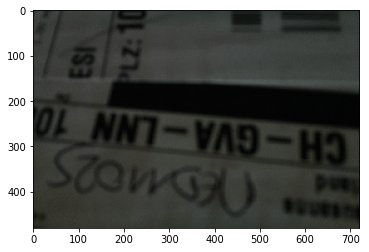

In [2]:
# Create the in-memory stream
stream = io.BytesIO()
with picamera.PiCamera() as camera:
    camera.start_preview()
    time.sleep(2)
    start = time.time()
    camera.capture(stream, format='bmp')
# "Rewind" the stream to the beginning so we can read its content
stream.seek(0)
img = Image.open(stream)
print(time.time() - start)
plt.imshow(img)

0.6158866882324219
0.6205649375915527


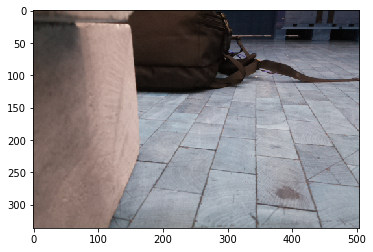

In [35]:
start = time.time()
camera.capture(IMAGES_PATH + "cam.bmp")
print(time.time() - start)
img = cv.imread(IMAGES_PATH + 'cam.bmp')
print(time.time() - start)
plt.imshow(img)

In [8]:
stream = io.BytesIO()
writing = False

def filenames(frames):
    frame = 0
    while frame < frames:
        yield 'testcam/image%02d.bmp' % frame
        frame += 1
        
class Thread_Cam(threading.Thread):
    def __init__(self, name):
        threading.Thread.__init__(self)
        self.name = name

    def run(self):
        global stream
        global writing
        with picamera.PiCamera() as camera:
            camera.resolution = (504, 336)
            camera.rotation = 180
            camera.framerate = 60
            camera.start_preview()
            # Give the camera some warm-up time
            time.sleep(2)
            while True:
                start = time.time()
                writing = True
                stream = io.BytesIO()
                camera.capture(stream, format='bmp')
                writing = False  
                time.sleep(0.01)
                finish = time.time()
                print("time to take stream: ", finish - start)
            
def camera_cap():
    frames = 19
    fps = []
    with picamera.PiCamera() as camera:
        camera.resolution = (504, 336)
        camera.rotation = 180
        camera.framerate = 60
        camera.start_preview()
        # Give the camera some warm-up time
        time.sleep(2)
        while(True):
            start = time.time()
            camera.capture_sequence(filenames(frames), use_video_port=True)
            finish = time.time()
            fps.append(frames / (finish - start))
            #print(finish - start)

In [9]:
'''thread_cam = Thread_Cam("thread_cam")
thread_cam.start()'''
t = threading.Thread(target=camera_cap,name="camera_cap")
t.daemon = True
t.start()

time to find cam:  0.006057024002075195
testcam/image06.bmp
time to read:  0.027846336364746094
finding bottles:  0.9225368499755859
bottle number:  8
calcul pos:  0.010355472564697266
total processing time: 0.9788124561309814


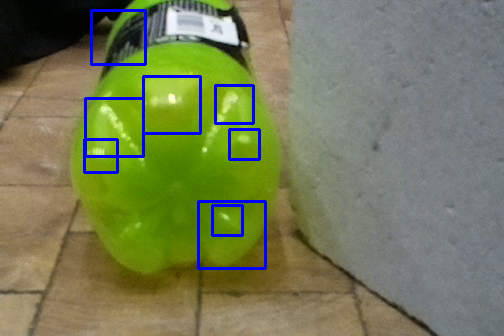

In [11]:
'''camera.capture(IMAGES_PATH + "cam.bmp")
img = cv.imread(IMAGES_PATH + 'cam.bmp')'''
big_start = time.time()
start_= time.time()
ts = 0    
m1, m2 = 0,0
found = None
last, before_last = 'testcam/image17.bmp','testcam/image17.bmp'
for file_name in glob.glob('testcam/*.bmp'):
    fts = os.path.getmtime(file_name)
    if fts >= m1:
        m1, m2 = fts, m1
        last, before_last = file_name, last
    elif fts > m2:
        m2 = fts
        before_last = file_name
    if fts > ts:
        ts = fts
        found = file_name
print("time to find cam: ", time.time() - start_)
print(before_last)
start_ = time.time()
img = cv.imread(before_last)
print("time to read: ",time.time() - start_)
start = time.time()
img_height, img_width = img.shape[:2] 
bottles = bottle_cascade.detectMultiScale(img, minNeighbors=10)
print("finding bottles: ", time.time() - start)
i = 0
start = time.time()
for (x,y,w,h) in bottles:
    center = calcul_low_center(x,y,w,h)
    dist, angle = calcul_bottle_dist_angle(center, img_width, img_height)
    cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    i = i + 1
print("bottle number: ", i)
print("calcul pos: ", time.time() - start)
print("total processing time:", time.time() - big_start)
cv.imwrite(IMAGES_PATH + "cam_haar.png", img)
ShowImage(filename = IMAGES_PATH + 'cam_haar.png')

taking captures:  0.4821920394897461
time to find cam:  0.0020818710327148438
time to read:  0.031005859375
finding bottles:  0.6969268321990967
bottle number:  2
calcul pos:  0.005951642990112305
total processing time: 0.7431640625
(336, 504, 3)


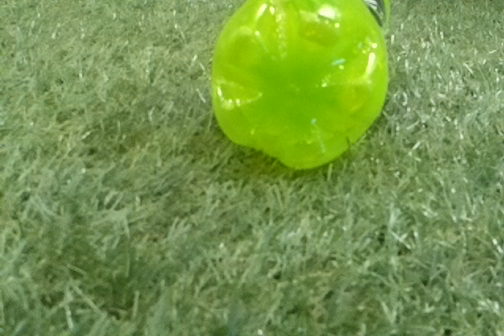

In [23]:
def filenames(frames):
    frame = 0
    while frame < frames:
        yield 'testcam/image%02d.bmp' % frame
        frame += 1
        
frames = 17
with picamera.PiCamera() as camera:
    camera.resolution = (504, 336)
    camera.rotation = 180
    camera.framerate = 60
    camera.start_preview()
    # Give the camera some warm-up time
    time.sleep(0.01)
    start = time.time()
    camera.capture_sequence(filenames(frames), use_video_port=True)
    print("taking captures: ", time.time() - start)
            
big_start = time.time()
start_= time.time()
file_names = glob.glob('testcam/*.bmp')
print("time to find cam: ", time.time() - start_)
img = cv.imread(file_names[-1])
print("time to read: ",time.time() - start_)
start = time.time()
img_height, img_width = img.shape[:2] 
bottles = bottle_cascade.detectMultiScale(img, minNeighbors=10)
print("finding bottles: ", time.time() - start)
i = 0
start = time.time()
for (x,y,w,h) in bottles:
    center = calcul_low_center(x,y,w,h)
    dist, angle = calcul_bottle_dist_angle(center, img_width, img_height)
    #cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    i = i + 1
print("bottle number: ", i)
print("calcul pos: ", time.time() - start)
print("total processing time:", time.time() - big_start)
print(img.shape)
cv.imwrite(IMAGES_PATH + "cam_haar.png", img)
ShowImage(filename = IMAGES_PATH + 'cam_haar.png')

In [ ]:

# Create a pool of image processors
done = False
lock = threading.Lock()
pool = []

class ImageProcessor(threading.Thread):
    def __init__(self):
        super(ImageProcessor, self).__init__()
        self.stream = io.BytesIO()
        self.event = threading.Event()
        self.terminated = False
        self.start()

    def run(self):
        # This method runs in a separate thread
        global done
        while not self.terminated:
            # Wait for an image to be written to the stream
            if self.event.wait(1):
                try:
                    big_start = time.time()
                    start = time.time()
                    self.stream.seek(0)
                    # Read the image and do some processing on it
                    imgRaw = Image.open(self.stream)
                    open_cv_image = np.array(imgRaw) 
                    # Convert RGB to BGR 
                    img = open_cv_image[:, :, ::-1].copy()
                    print("read picture: ", time.time() - start)

                    start = time.time()
                    img_height, img_width = img.shape[:2] 
                    bottles = bottle_cascade.detectMultiScale(img, minNeighbors=10)
                    print("finding bottles: ", time.time() - start)
                    i = 0
                    start = time.time()
                    for (x,y,w,h) in bottles:
                        center = calcul_low_center(x,y,w,h)
                        dist, angle = calcul_bottle_dist_angle(center, img_width, img_height)
                        cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
                        i = i + 1
                    print("bottle number: ", i)
                    print("calcul pos: ", time.time() - start)
                    print("total processing time:", time.time() - big_start)
                    #...
                    #...
                    # Set done to True if you want the script to terminate
                    # at some point
                    #done=True
                finally:
                    # Reset the stream and event
                    self.stream.seek(0)
                    self.stream.truncate()
                    self.event.clear()
                    # Return ourselves to the pool
                    with lock:
                        pool.append(self)

def streams():
    while not done:
        with lock:
            if pool:
                processor = pool.pop()
            else:
                processor = None
        if processor:
            yield processor.stream
            processor.event.set()
        else:
            # When the pool is starved, wait a while for it to refill
            time.sleep(0.1)

with picamera.PiCamera() as camera:
    start = time.time()
    pool = [ImageProcessor() for i in range(4)]
    camera.resolution = (504, 336)
    camera.rotation = 180
    camera.framerate = 40
    camera.start_preview()
    time.sleep(2)
    camera.capture_sequence(streams(), use_video_port=True)
    print("taking picture: ", time.time() - start)

# Shut down the processors in an orderly fashion
while pool:
    with lock:
        processor = pool.pop()
        print("hey")
    processor.terminated = True
    processor.join()

read picture:  0.09194231033325195
read picture:  0.14168810844421387
read picture:  0.10422587394714355
read picture:  0.20020461082458496
finding bottles:  0.8231613636016846
bottle number:  0
calcul pos:  0.000415802001953125
total processing time: 0.9184346199035645
read picture:  0.09554052352905273


In [2]:
camera = picamera.PiCamera()
camera.rotation = 180
camera.resolution = (504, 336)
bottle_cascade = cv.CascadeClassifier(utils + 'biggest_haar.xml')

taking picture:  0.4961965084075928
read picture:  0.004522562026977539
finding bottles:  0.3933145999908447
bottle number:  0
calcul pos:  0.00041556358337402344
total processing time: 0.8972387313842773
0
taking picture:  0.5064113140106201
read picture:  0.0038709640502929688
finding bottles:  0.3950386047363281
bottle number:  0
calcul pos:  0.0004146099090576172
total processing time: 0.90836501121521
0
taking picture:  0.5055303573608398
read picture:  0.0040013790130615234
finding bottles:  0.39121556282043457
bottle number:  0
calcul pos:  0.0004150867462158203
total processing time: 0.9037864208221436
0
taking picture:  0.5259296894073486
read picture:  0.003831624984741211
finding bottles:  0.39086270332336426
bottle number:  0
calcul pos:  0.0004181861877441406
total processing time: 0.9237325191497803
0


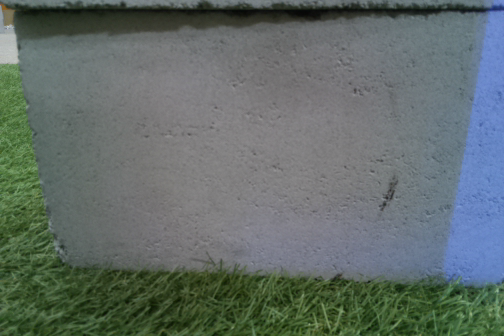

In [12]:
with picamera.PiCamera() as camera:
    camera.resolution = (504, 336)
    camera.rotation = 180
    camera.framerate = 60
    camera.start_preview()
    # Give the camera some warm-up time
    time.sleep(2)
    c = 0
    while(True):
        big_start = time.time()
        start = time.time()
        camera.capture(IMAGES_PATH + "cam.bmp")
        print("taking picture: ", time.time() - start)
        start = time.time()
        img = cv.imread(IMAGES_PATH + 'cam.bmp')
        print("read picture: ", time.time() - start)

        start = time.time()
        img_height, img_width = img.shape[:2] 
        bottles = bottle_cascade.detectMultiScale(img, minNeighbors=10)
        print("finding bottles: ", time.time() - start)
        i = 0
        start = time.time()
        for (x,y,w,h) in bottles:
            center = calcul_low_center(x,y,w,h)
            dist, angle = calcul_bottle_dist_angle(center, img_width, img_height)
            #cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
            i = i + 1
        print("bottle number: ", i)
        print("calcul pos: ", time.time() - start)
        print("total processing time:", time.time() - big_start)
        print(i)
        c = c + 1
        if c > 3:
            break
cv.imwrite(IMAGES_PATH + "cam_haar.png", img)
ShowImage(filename = IMAGES_PATH + 'cam_haar.png')

In [8]:
camera.close()

In [27]:
import datetime
def record_video():
    filename = "recording_" + str(datetime.datetime.now().strftime("%Y%m%d_%H%M%S")) + ".h264"
    camera.start_preview()
    camera.start_recording(filename)

def finish_video():
    camera.stop_recording()
    camera.stop_preview()

record_video()
time.sleep(60)
finish_video()

KeyboardInterrupt: 

# Close connection and camera

In [20]:
camera.close()

In [9]:
close_connection(s)

In [ ]:
[[1000,2600,0],[6500,2600,0],[6500,5000,0],[4500,5000,0],[4500,7500,0],[3800,7500,0],[3800,5500,0],[7500,5500,0],[7500,500,0],[2500,500,0],[2500,4000,0],[7000,4000,0],[7000,1500,0],[3500,1500,0],[700,3500,0],[5500,3500,0],[5500,4200,0],[700,4200,0]]